# Multiple classifiers

We will attempt to create methods to train and evaluate multiple multi-output classifier and rank them based on F2 score

Given we were not able to create a good balanced dataset, we will test using original dataset with reduced features 

In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xb

In [4]:
X_train=pd.read_csv('data/X_train.csv')
y_train=pd.read_csv('data/y_train.csv')
X_test=pd.read_csv('data/X_test.csv')
y_test=pd.read_csv('data/y_test.csv')

y_train_omf = y_train['Machine failure']
y_test_omf = y_test['Machine failure']

X_train_reduced = X_train.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])
X_test_reduced = X_test.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])

print(X_train_reduced.columns)
print(y_test.columns)

Index(['Type', 'Rotational speed (rpm)', 'Tool wear (min)', 'Strain (minNm)',
       'Power (W)', 'Temperature Difference (K)'],
      dtype='object')
Index(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], dtype='object')


Let's optimise our parameters for XGBoost, Decision Tree and Random Forest

In [20]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score


def optimize(label, param_grid, clf, X_train, y_train):
    f2_scorer = make_scorer(fbeta_score, beta=2)
    # Create an instance of the GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=f2_scorer)

    if isinstance(y_train, pd.DataFrame):
        # Fit the GridSearchCV to the data
        grid_search.fit(X_train, y_train['Machine failure'])
    else:
        grid_search.fit(X_train, y_train)
    # Print the best set of hyperparameters
    print(label, " best hyperparameters: ", grid_search.best_params_)


dt_param_grid = {'criterion': ["gini", "entropy"],
                 'max_depth': [5, 10],
                 'min_samples_leaf': [10, 20, 30],
                 'min_samples_split': [20, 30, 40]
                 }
dt = DecisionTreeClassifier(random_state=42)

crf_param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [5, 10, 20, 100]
}
crf = RandomForestClassifier(random_state=42)
cxb_param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, 20, 100]
}
cxb = XGBClassifier(objective='binary:logistic', random_state=42)

optimize("Decision Tree", dt_param_grid, dt, X_train_reduced, y_train)
optimize("Random Forest", crf_param_grid, crf, X_train_reduced, y_train)
optimize("XG Boost", cxb_param_grid, cxb, X_train_reduced, y_train)

Decision Tree  best hyperparameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 20}
Random Forest  best hyperparameters:  {'criterion': 'gini', 'max_depth': 10}
XG Boost  best hyperparameters:  {'max_depth': 10, 'n_estimators': 10}


- Decision Tree  best hyperparameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 20}
- Random Forest  best hyperparameters:  {'criterion': 'gini', 'max_depth': 10}
- XG Boost  best hyperparameters:  {'max_depth': 10, 'n_estimators': 10}

Create our evaluator function

In [11]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.multioutput import MultiOutputClassifier

def get_ml_perf_machine_failure(name, clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target='Machine failure'):
    y_train_omf = y_train[target]
    y_test_omf = y_test[target]
    clf = MultiOutputClassifier(clf)
    clf.fit(X_train, y_train)
    y_train_pred= clf.predict(X_train)
    y_train_pred = pd.DataFrame(y_train_pred, columns=y_test.columns)
    y_test_pred = clf.predict(X_test)
    y_test_pred = pd.DataFrame(y_test_pred, columns=y_test.columns)
    y_test_pred_omf = y_test_pred[target]
    y_train_pred_omf = y_train_pred[target]
    f2_train=fbeta_score(y_train_omf, y_train_pred_omf, beta=2)
    f2_test=fbeta_score(y_test_omf, y_test_pred_omf, beta=2)
    train_recall=recall_score(y_train_omf, y_train_pred_omf)
    test_recall=recall_score(y_test_omf, y_test_pred_omf)
    train_precision=precision_score(y_train_omf, y_train_pred_omf, zero_division=0)
    test_precision=precision_score(y_test_omf, y_test_pred_omf, zero_division=0)
    train_accuracy=accuracy_score(y_train_omf, y_train_pred_omf)
    test_accuracy=accuracy_score(y_test_omf, y_test_pred_omf)
    predictor_name = clf.__class__.__name__
    cm = confusion_matrix(y_train_omf, y_train_pred_omf)
    train_tn, train_fp, train_fn, train_tp = cm.ravel()
    cm = confusion_matrix(y_test_omf, y_test_pred_omf)
    test_tn, test_fp, test_fn, test_tp = cm.ravel()
    result = {
        "multi-output-classifier": clf,
        "f2_train": f2_train,
        "f2_test": f2_test,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_recall":train_recall,
        "test_recall": test_recall,
        "test_precision": test_precision,
        "train_precision":train_precision,
        "predictor_name": predictor_name,
        "train_fp": train_fp,
        "train_fn": train_fn,
        "test_fp": test_fp,
        "test_fn": test_fn,
        "train_tp": train_tp,
        "train_tn": train_tn,
        "test_tp": test_tp,
        "test_tn": test_tn,
        "test_pred": y_test_pred,
        "train_pred": y_train_pred,
        "name": name        
    }
    return result

def evaluate_models(models:dict,  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target='Machine failure'):
    results = []
    print("Evaluate models for ", target)
    for name, model in models.items():
        results.append(get_ml_perf_machine_failure(name, model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target=target))
    results.sort(reverse=True, key=lambda result: (result["f2_test"],result["test_accuracy"]))
    print(" -- Sorted result --")
    for result in results:
        print(f"{result["name"]:20} : f2-test {result["f2_test"]:20} | test-fn {result["test_fn"]:10} | test-fp {result["test_fp"]:10}  | f2-train {result["f2_train"]:20} | test accuracy {result["test_accuracy"]:10}| train accuracy {result["train_accuracy"]:10}")
    return results

Evaluate

In [21]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "XGBoost",
    "SVC"
]
# Decision Tree  best hyperparameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 20}
# Random Forest  best hyperparameters:  {'criterion': 'gini', 'max_depth': 10}
# XG Boost  best hyperparameters:  {'max_depth': 10, 'n_estimators': 10}
classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=30, min_samples_split=20),
    RandomForestClassifier(random_state=42, max_depth=10),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    XGBClassifier(n_estimators=10,objective='binary:logistic',random_state=42, max_depth=10),
    SVC()
]

models = {name: clf for name, clf in zip(names, classifiers)}
results_reduced = evaluate_models(models, X_train=X_train_reduced, X_test=X_test_reduced, target='Machine failure') # use reduced features

best_clf = results_reduced[0]["multi-output-classifier"]

best_clf


Evaluate models for  Machine failure
 -- Sorted result --
Random Forest        : f2-test   0.8840579710144928 | test-fn          9 | test-fp          4  | f2-train   0.8600148920327625 | test accuracy     0.9935| train accuracy   0.994125
Decision Tree        : f2-test   0.8664772727272727 | test-fn          9 | test-fp         11  | f2-train   0.8284671532846716 | test accuracy       0.99| train accuracy    0.98975
XGBoost              : f2-test   0.8430232558139535 | test-fn         12 | test-fp          6  | f2-train     0.85003711952487 | test accuracy      0.991| train accuracy   0.993125
AdaBoost             : f2-test   0.4716981132075472 | test-fn         40 | test-fp          8  | f2-train  0.47351524879614765 | test accuracy      0.976| train accuracy      0.978
Naive Bayes          : f2-test  0.41420118343195267 | test-fn         42 | test-fp         30  | f2-train   0.4241741741741742 | test accuracy      0.964| train accuracy      0.966
Nearest Neighbors    : f2-test  0.401

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                       random_state=42))

In [23]:
import pprint
# pprint.pprint(best_clf.get_params())
pprint.pprint(best_clf.estimator.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Train Best Predictor

In [24]:
best_clf = RandomForestClassifier(random_state=42, max_depth=10)
best_clf = MultiOutputClassifier(best_clf)
best_clf.fit(X_train_reduced, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                       random_state=42))

One of the problem we discovered in our earlier attempt to use Decision Tree is the failure to detect TWF

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

def display_cm(pred, actual):
    no_of_label = len(pred.columns)
    i = 0
    no_of_column = 6
    left_over = no_of_label % no_of_column
    no_of_row = no_of_label // no_of_column+left_over
    plt.figure(figsize=(30,5))
    for label in pred.columns:
        i +=1
        ax=plt.subplot(no_of_row, no_of_column, i)
        cm = confusion_matrix(actual[label],pred[label])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['P', 'F'])
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title(label=label)
    plt.show()

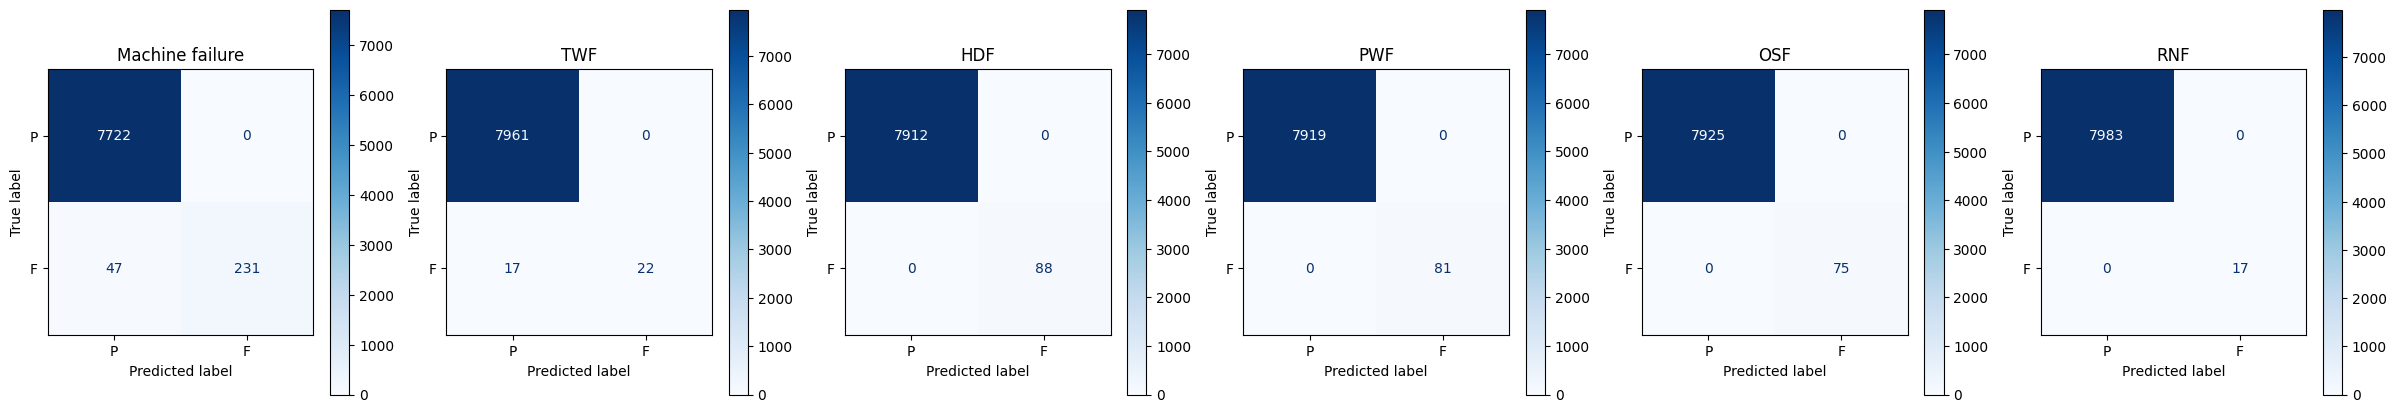

In [26]:
y_pred=best_clf.predict(X_train_reduced)
y_pred = pd.DataFrame(y_pred, columns=y_train.columns)

# Custom thresholds (e.g., [0.4, 0.4, 0.5])
"""
y_probs = best_clf.predict_proba(X_train_reduced)
thresholds = [0.5,0.4, 0.5,0.5,0.5,0.5]
custom_preds = np.column_stack([
    (y_probs[i][:, 1] > thresholds[i]).astype(int) for i in range(y_train.shape[1])
])
y_pred = pd.DataFrame(custom_preds, columns=y_train.columns)

"""
display_cm(y_pred, y_train)

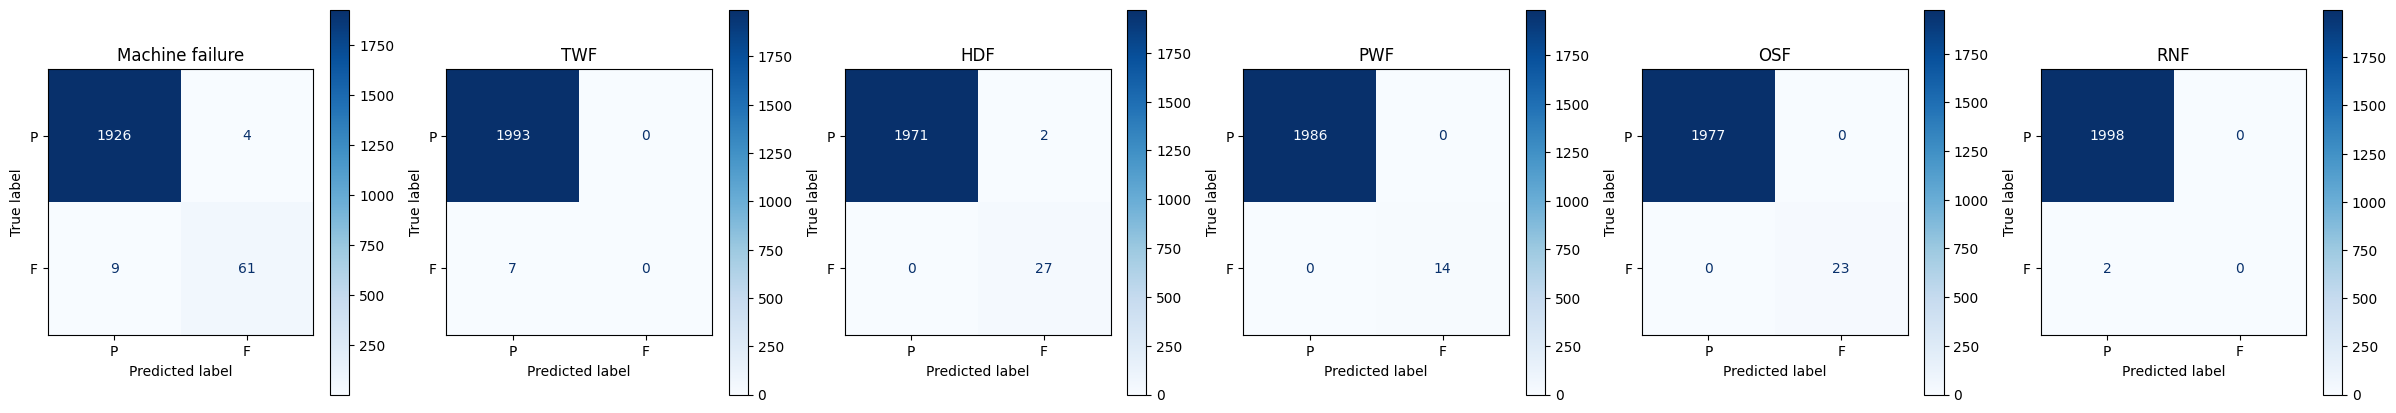

In [27]:
y_pred=best_clf.predict(X_test_reduced)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
display_cm(y_pred, y_test)

## Use `Ensemble` of each label predictor

Based on confusion matrix, we might be able to predict machine failure better if we train multiple predictor on separate failures rather than trying to predict `Machine Failure`

We can then combine it using simple check if any failure is true then `Machine Failure` is true too



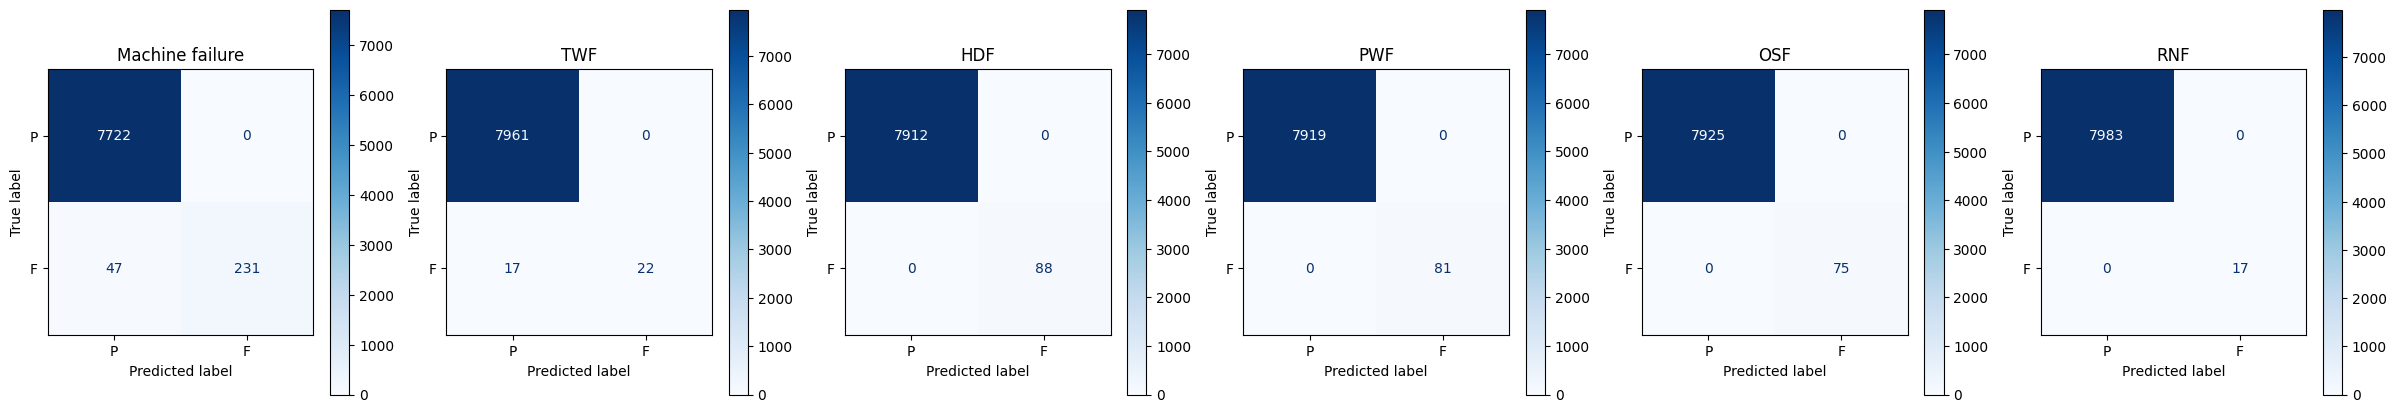

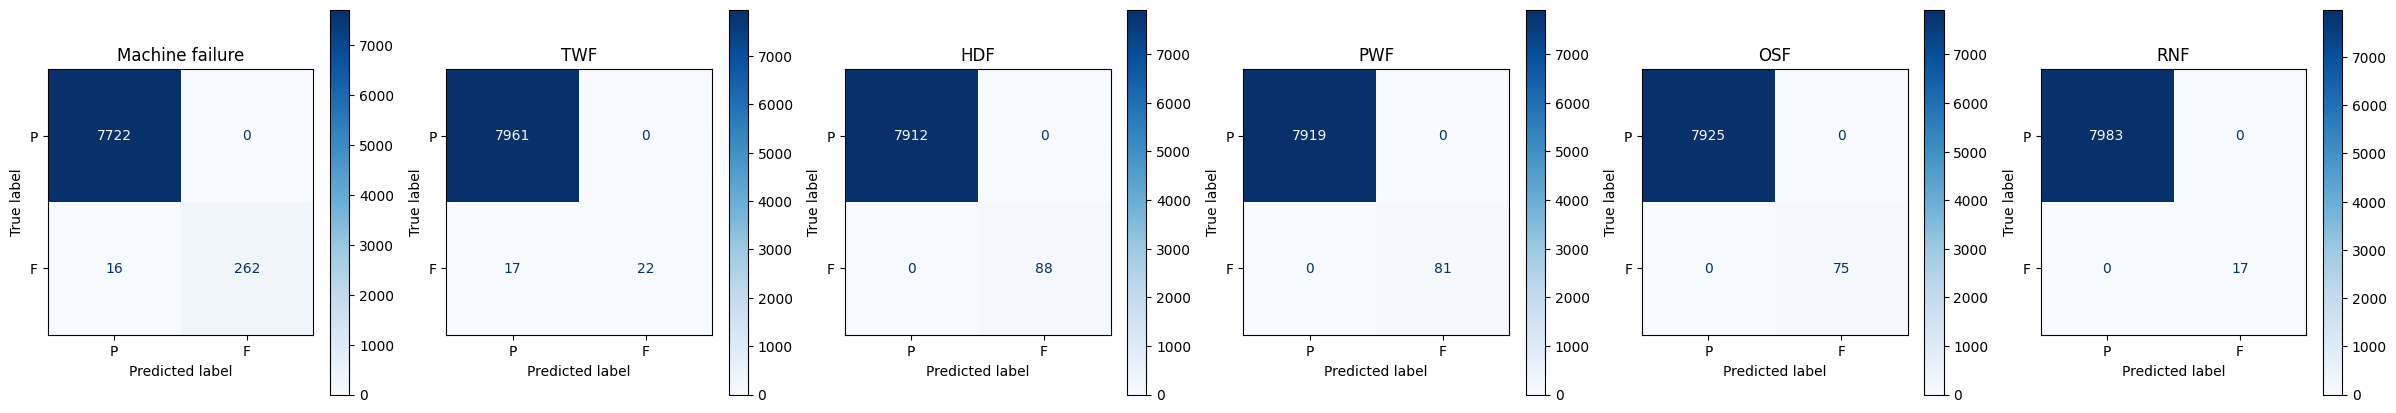

In [32]:
y_pred=best_clf.predict(X_train_reduced)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
display_cm(y_pred, y_train)
y_pred['Machine failure']=np.where((y_pred['HDF']==1)|(y_pred['PWF']==1)|(y_pred['OSF']==1)|(y_pred['TWF']==1)|(y_pred['RNF']==1),1,0)
display_cm(y_pred, y_train)

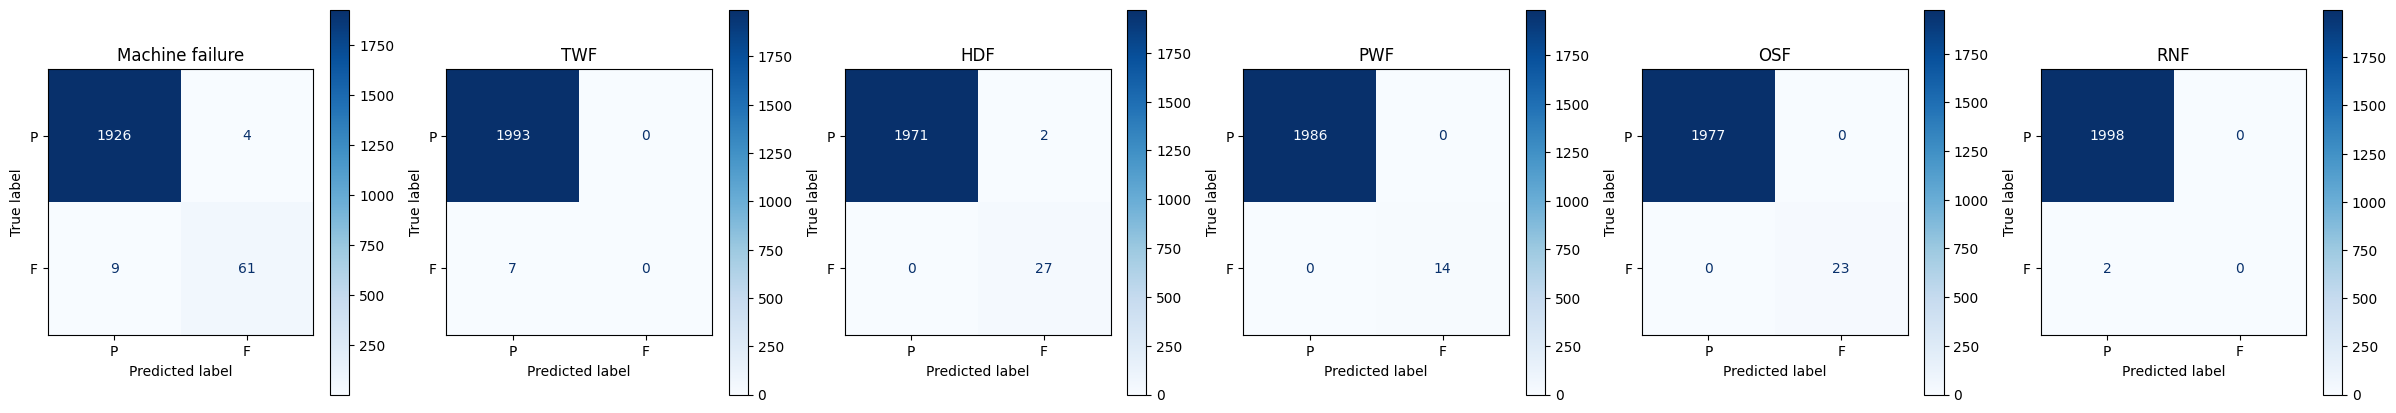

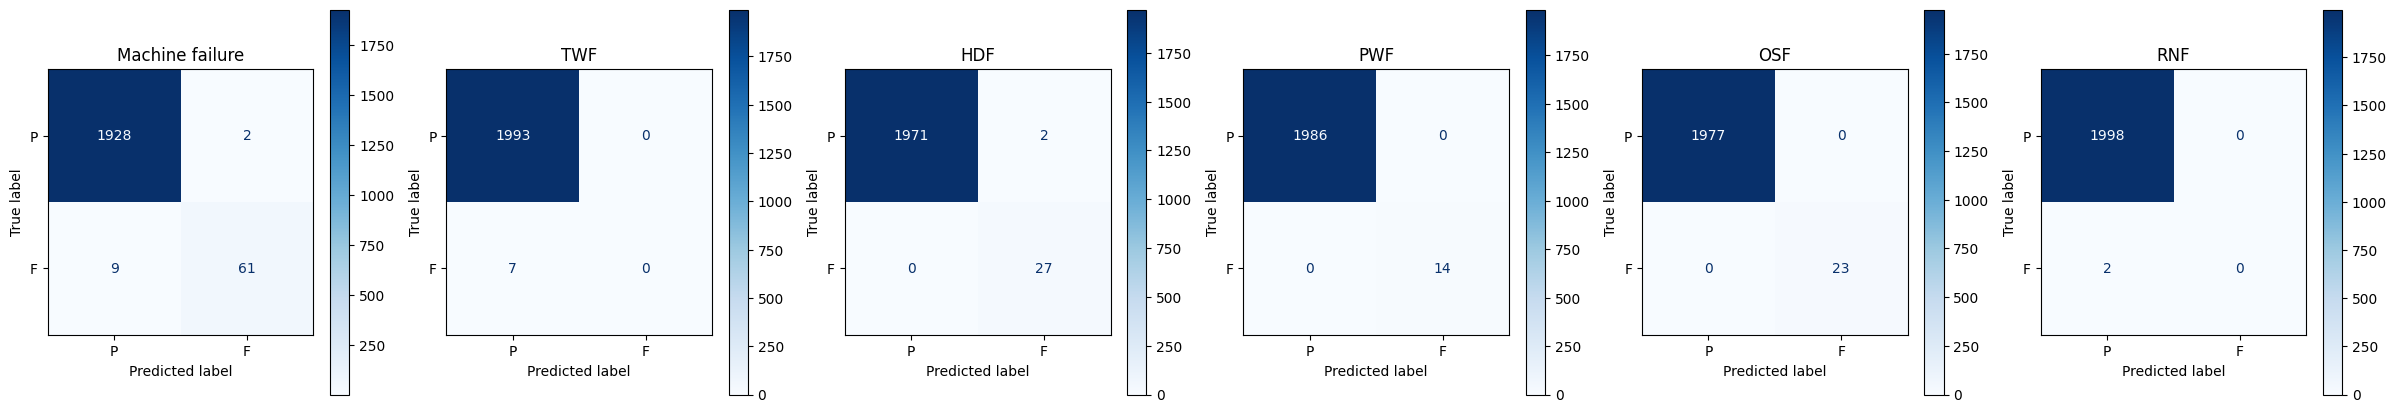

In [29]:
y_pred=best_clf.predict(X_test_reduced)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
display_cm(y_pred, y_test)
y_pred['Machine failure']=np.where((y_pred['HDF']==1)|(y_pred['PWF']==1)|(y_pred['OSF']==1)|(y_pred['TWF']==1)|(y_pred['RNF']==1),1,0)
display_cm(y_pred, y_test)

### Save Best Classifier/Predictor

In [33]:
import pickle
with open('ml_predictor.pkl', 'wb') as f:
    pickle.dump(best_clf, f)
print("Best ML Predictor model saved to 'ml_predictor.pkl'")

Best ML Predictor model saved to 'ml_predictor.pkl'


## Conclusion

Using Random Forest and forming an ensemble of each individual failure label predictor we can obtain best classifier